# Input Sampling notebook

---

This notebook is used to create an initial dataset, by sampling from multiple sources from the internet.
The goal is to obtain multiple formats of files that create visual outputs:
- svg
- tikz
- html-css-js
- ascii art
- P5js
- scad

The output will be a huggingface dataset with only image and code(pil image ans str)

## SVG

#### Selected source
- https://huggingface.co/datasets/ServiceNow/svg-emoji
#### Policies
- No \<animate>, \<animateMotion>, \<animateTransform>, \<set>
- No <text>
- At least one of (\<circle>,\<rect>,\<ellipse>,\<polygon>,\<polyline>,\<line>)
- Number of characters > Cmin
- Number of characters < Cmax

#### Statistics

In [ ]:
import re
from datasets import load_dataset

from input_utils import SvgFilters

ds_initial = load_dataset("ServiceNow/svg-emoji",split="train")

SvgFilters.statistics(ds_initial)

#### Filtering

In [ ]:
ds = ds_initial.filter(SvgFilters.noAnimations, desc="filtering out animated svgs")
ds = ds.filter(SvgFilters.noText, desc="filtering out svgs with texts")
ds = ds.filter(SvgFilters.hasBasicShape, desc="filtering out svgs without basic shapes")
ds = ds.filter(
    SvgFilters.maxCharacters,
    desc="filtering svgs under 4500 caracters and over 500",
)
ds.cleanup_cache_files()

#### Pushing the current subset

In [ ]:
ds = ds.rename_columns({"Filename":"name","Svg":"code"})
ds.push_to_hub("CharlyR/varbench-inputs", config_name="svg", split="auto_filtered")


## TIKZ

#### Selected source
- nllg/datikz
- CharlyR/varbench => source codes do not need to be filtered
#### Policies
- Has any comments => more chances of having challenging TikZ
  - Then Remove comments
- between 1700 and 2300 characters=> to match varbench, not too easy not too hard
- more than 3 \draw or \fill directives
- only one \begin{tikzpicture}
- Source not gpt4 chatgpt => "after manual exploration of the dataset, we found that tikz codes coming from gpt4 or chatgpt sources were too simple and not representative of real scientific diagrams"

#### Pulling dataset

In [126]:
from datasets import load_dataset,Dataset
from input_utils import TikzUtils
ds:Dataset = load_dataset("nllg/datikz",split="train")
#ds.cleanup_cache_files()

#### Statistics

computing length of the code: 100%|██████████| 49692/49692 [00:04<00:00, 10230.63 examples/s]


-1158.5
3709.5


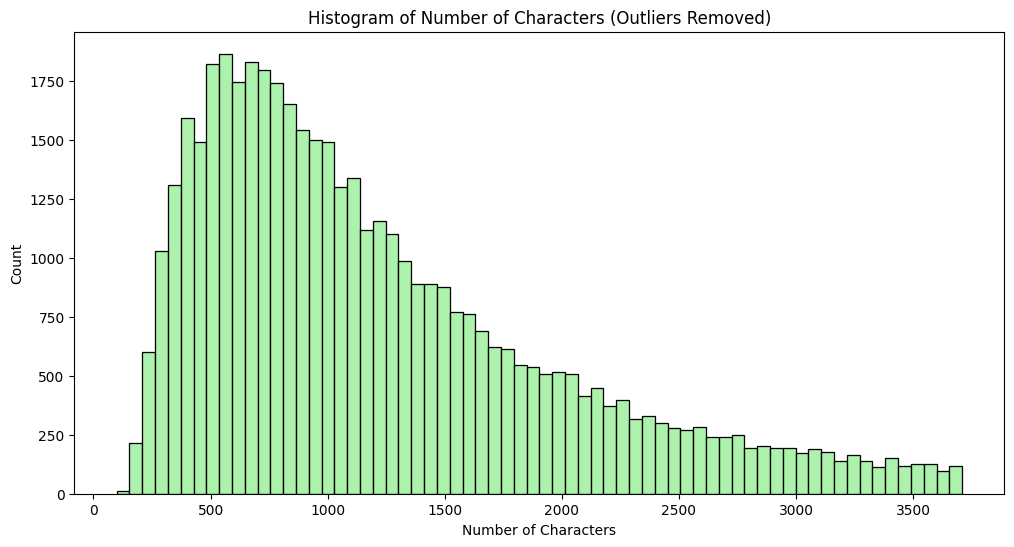

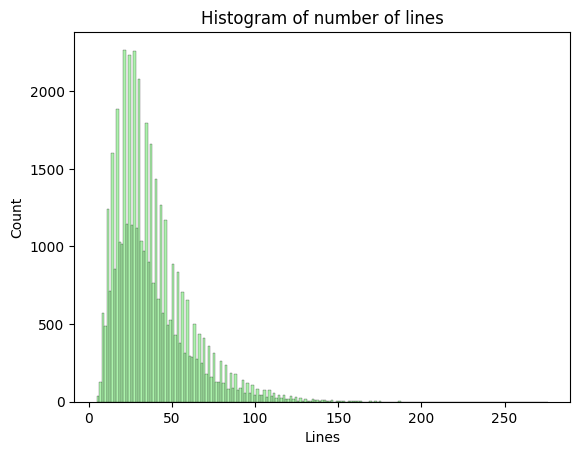

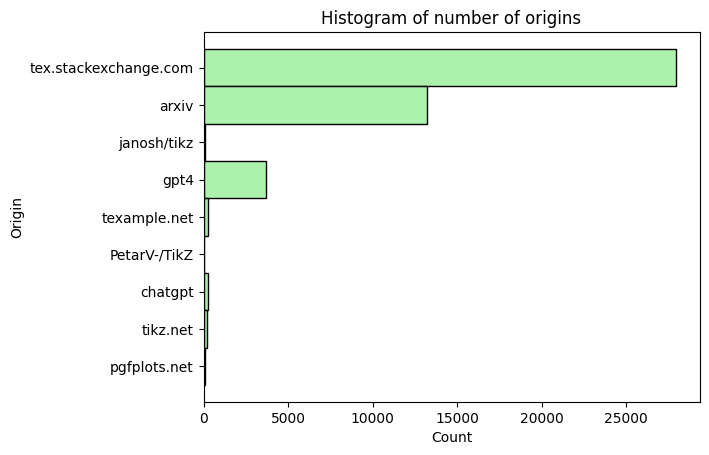

In [3]:

TikzUtils.statistics(ds)#outliers removed



### Filtering and modifications

In [127]:
ds = ds.filter(TikzUtils.Filters.hasComments, desc="filtering out tikz without comments")
print(len(ds))
ds = ds.map(TikzUtils.Modifications.removeComments, desc="Removing comments")
print(len(ds))
ds = ds.filter(TikzUtils.Filters.characterLength, desc="filtering out tikz with character lenght l:700<l<3570")
print(len(ds))
#ds = ds.filter(TikzUtils.Filters.lineLength, desc="filtering out tikz with line lenght l:50<l<80")
#print(len(ds))
ds = ds.filter(TikzUtils.Filters.hasBasicShape, desc="filtering out tikz without basic tikz shapes")
print(len(ds))
ds = ds.filter(TikzUtils.Filters.oneTikzPicture, desc="filtering out tikz with only one \\begin{tikzpicture}")
print(len(ds))
ds = ds.filter(TikzUtils.Filters.noLLMorigin, desc="filtering out tikz with LLM origin")
print(len(ds))


7975
7975
5606
3001
2750
2750


##### manual exploration

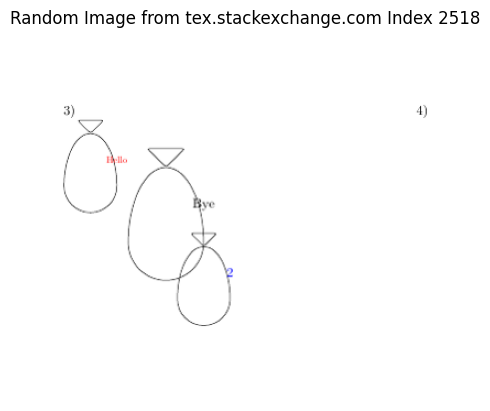

https://tex.stackexchange.com/a/632144


In [121]:
import random
import matplotlib.pyplot as plt
from PIL import Image
tmpds = ds

# Pick a random index
idx = random.randint(0, len(tmpds) - 1)
# Load image
image = tmpds[idx]["image"]  # Adjust key if needed
# Convert to PIL image if necessary
if isinstance(image, dict) and "bytes" in image:
    image = Image.open(io.BytesIO(image["bytes"]))
# Display image
plt.imshow(image)
plt.axis("off")
plt.title(f"Random Image from {tmpds[idx]["origin"]} Index {idx}")
plt.show()
with open("tmp.tex","w") as t:
    t.write(tmpds[idx]["full_code"])
print(tmpds[idx]["uri"])

#### Manual Selection

In [60]:
import matplotlib.pyplot as plt
id=0

In [ ]:
tmpds = ds
potentials = [764,969,2379,444,1816,47,1343,902,201,639,667,238,2355,1976,584,1761,599,1149,221,709,1211,1251,342,2593,-1,1117,825,1014,69,1235,1448,2700,2005,2552,2387]#-1 is feynman diagram, did not write it
print(len(potentials))

image = tmpds[potentials[id]]["image"]  # Adjust key if needed
# Convert to PIL image if necessary
if isinstance(image, dict) and "bytes" in image:
    image = Image.open(io.BytesIO(image["bytes"]))
# Display image
plt.imshow(image)
plt.axis("off")
plt.title(f"Index {id}=> {potentials[id]}")
plt.show()
with open("tmp.tex","w") as t:
    t.write(tmpds[potentials[id]]["full_code"])
print(tmpds[potentials[id]]["uri"])
print(tmpds[potentials[id]]["augmented"])
id+=1

#### Pushing the current subset

In [128]:

import datasets
import pandas as pd
ds.push_to_hub("CharlyR/varbench-inputs", config_name="auto_filtered", split="train")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/varbench-inputs/commit/edc87bee6ada663e8919c655c31a251df11ccf21', commit_message='Upload dataset', commit_description='', oid='edc87bee6ada663e8919c655c31a251df11ccf21', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/varbench-inputs', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/varbench-inputs'), pr_revision=None, pr_num=None)

## P5js

#### Selected source
- https://happycoding.io/tutorials/p5js/ ?
- https://openprocessing.org/discover/#/trending
#### treatment
- Comments removal
#### Policies
- handpicked example from the sites